<img src="images/EEFR_Logo.png" width='400'>

# EEFR Project: The Basics

Women are underrepresented in academic STEM fields. Why? And what can we do about it?

# Agenda for Today

1. Overview of the EEFR Project
2. Preliminary Results
3. Deep(er) Dive on Dictionary Validation

## Extent of women's underrepresentation in STEM fields

<img src="images/Underrepresentation.png" width='600'>

## Historical mechanism: _de jure_ sex segregation

<br>
<img src="images/FemaleAd.png" width="300" align="left">
<img src="images/MaleAd.png" width="300" float="left">
<br>

## Change in law: 1964 Civil Rights Act

    "It shall be an unlawful employment practice ... to print or publish or cause to be printed or published any
    notice or advertisement relating to employment ... indicating any preference, limitation, specification, or
    discrimination, based on race, color, religion, sex, or national origin ..."

[42 U.S.C. § 2000e-3(b)](https://www.law.cornell.edu/uscode/text/42/2000e-3)

## Present-Day _de facto_ sex segregation: sex stereotyping
<img src="images/Gorman.png" width="300" align="left">
<img src="images/Gaucher.png" width="350" float="left">

## Commercial efforts to address gendered job ad language
<br>
<img src="images/Gender_Decoder.png" width="400" align="left">
<img src="images/Textio.png" width="400" float="left">
<br>

## Sex stereotyping: descriptive and prescriptive

<img src="images/DescrPrescr.png" width="600">

# Research Questions:

1. To what extent does the sex segregation of a department or field predict gendered language in job descriptions?

2. To what extent does gendered language in a job description correspond to sex-differentiated hiring outcomes?

The research I'm discussing today focuses on the first question. We intend to continue to the second question and to examine additional parts of the hiring process (e.g., letters of recommendation) in subsequent work.

# Overview of Data and Methods

<img src="images/Grimmer_Stewart_Fig1.png" width='400'>

__Data Source:__ Evaluating Equity in Faculty Recruitment data set

* 10 Campuses
* Carnegie R1 universities
* Field-level demographic information
* Department-level demographic information
* Job descriptions

__Methods:__ Dictionary analysis

* Normalized token counts (i.e., proportions)
* Dictionaries representing facets of gendered language
    * Masculine vs. Feminine
    * Agentic vs. Communal
    * Research vs. Teaching
    * Ability vs. Grindstone
    * Standout
    * Family-friendly

# Text Analysis

## Pre-processing

These steps comprise the text pre-processing performed in this notebook. The specific steps we take, and the rationale for each, are as follows:

* _Make text lowercase._ We eliminate capitalization to standardize words and facilitate matching.
* _Remove URLs and emails._ Web addresses and email addresses are common in job descriptions, but do not convey substance about the job or the applicant.
* _Remove slashes and hyphens._ Because these are used inconsistently, and we are interested in word units, slashes and hyphens can mislead. Note that we except hyphenated terms of interest (e.g., the masculine term "self-confident") and do not eliminate hyphens in such terms.
* _Standardize abbreviations._ This step facilitates matching.
* _Correct processing errors._ Sometimes text entered in one application will not render correctly in another application, instead producing gibberish characters. We remove these because they are uninterpretable.
* _Eliminate punctuation._ Because we are interested in words, rather than sentences, punctuation is not helpful.
* _Eliminate numbers._ Because we are interested in words, numbers are not helpful to our analysis.
* _Tokenize text._ This separates the job description string of words into individual word units.
* _Identify compound expressions._ Where our lists of gendered terms contain phrases, as opposed to words, we identify these phrases in the job descriptions.
* _Remove stopwords._ We exclude common words, such as articles, because they are not likely to convey the sort of signaling information of theoretical interest.

In [1]:
# import modules and libraries
import pandas as pd
from datetime import datetime
import dicts_helpers as dh
import data_cleaners as dc
import descriptive_stats as ds
import dtm_based_analysis as dba
import viz_helpers as vh

# set global variables for use later
gs = {'time':datetime.now().isoformat(sep='_', timespec='seconds').replace(':', '-'),\
      'input_path':'../data/input_data/',\
      'currout_path':'../data/current_results/',\
      'arcout_path':'../data/data_archive/',\
      'dicts_path':'../data/dict_data/'}

# read in data
master_data = pd.read_csv(gs['input_path']+'recruit_data_current.csv', \
                          index_col='CASE_ID', \
                          converters={'campus_id':str,\
                                      'listing_department_id_01':str,\
                                      'CIP_code':str})

print('Data read.')
print()
print(f'There are {len(master_data)} cases in the data set.')

Data read.

There are 2721 cases in the data set.


In [2]:
# filter data
mod_data = dc.filter_missing(master_data, gs)
mod_data = dc.filter_medical(mod_data, gs)
mod_data = dc.filter_noise(mod_data, gs)

print(f'There are {len(mod_data)} cases in the filtered data set.')

/Users/matthewcannon/Desktop/Briefcase/KT_Research_Projects/STEM/CTAWG/scripts/data_cleaners.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  current_data['med_dummy'] = ''
/Users/matthewcannon/Desktop/Briefcase/KT_Research_Projects/STEM/CTAWG/scripts/data_cleaners.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gen_med_dummy(row['campus_id'], row['CIP_family'], row['college'], row['dept_name']), axis=1)


There are 1827 cases in the filtered data set.


In [3]:
# parse dictionaries
base_dicts = dh.build_dicts(gs['dicts_path'])

Parsed gaucher_masculine_v2.txt successfully.
Parsed gaucher_feminine_v2.txt successfully.
Parsed superlatives_v2.txt successfully.
Parsed communal_orientation_v2.txt successfully.
Parsed grindstone_adjectives_v2.txt successfully.
Parsed ability_words_v2.txt successfully.
Parsed agentic_orientation_v2.txt successfully.
Parsed gorman_masculine_traits_v2.txt successfully.
Parsed gorman_feminine_traits_v2.txt successfully.
Parsed family_friendly_v2.txt successfully.
Parsed teaching_words_v2.txt successfully.
Parsed research_words_v2.txt successfully.


In [5]:
# text cleaning and processing
stopwords = dc.gen_stops(base_dicts)
mod_data['descr_tokens'] = mod_data['description'].apply(lambda x: \
        dc.text_proc_nltk(x, base_dicts, stopwords))

# outputting sample tokenized job description
print('SAMPLE DESCRIPTION AS INPUT:')
print()
print(dc.quick_mask(mod_data['description'][2]))
print()
print('SAMPLE TOKENIZED DESCRIPTION:')
print(dc.quick_mask(mod_data['descr_tokens'][2]))

SAMPLE DESCRIPTION AS INPUT:

All research areas will be considered, but our program and campus has focus areas in in tissue engineering, with an emphasis on mechanobiology, epigenetics, biomaterials, and stem cell biology.  The candidate for this particular position should demonstrate proficiency at the intersection of all of these different research disciplines, while maintaining an engineering approach to solve regenerative medicine challenges.  The candidate is expected to have a doctoral degree in biomedical engineering or other related engineering fields. In addition, the successful candidate will be expected to advise students and teach undergraduate and graduate courses as well as develop collaborative programs with other faculty members and programs at ---.  The University of --- --- is situated in Orange CountyÃ¢ÂÂs rapidly growing high technology sector that includes more than 310 biomedical companies which are actively involved in our program.

SAMPLE TOKENIZED DESCRIPTIO

In [6]:
# create document-term matrix
# using sk-learn's CountVectorizer w/ str.split as analyzer
features, freq_df = dba.generate_dfs(mod_data)

# remove short descriptions and any features that only they contain
freq_df_trunc, mod_data_trunc = dc.filter_short(freq_df, mod_data, gs)
freq_df_trunc, features_trunc = dba.filter_dropped_features(freq_df_trunc, 'short', gs)

print('DTM created and short cases removed.')

DTM created and short cases removed.


There are 1800 cases in the data set.


The counts by campus ID are as follows:

campus: 6 count: 318

campus: 4 count: 258

campus: 9 count: 254

campus: 3 count: 247

campus: 1 count: 203

campus: 7 count: 185

campus: 2 count: 176

campus: 8 count: 86

campus: 5 count: 73


The counts by recruitment year are as follows:

year: 16 count: 559

year: 15 count: 478

year: 17 count: 413

year: 14 count: 350


The STEM/Non-STEM breakdown is as follows for UCOP:

STEM Flag: STEM count: 862

STEM Flag: NON-STEM count: 604


The STEM/Non-STEM breakdown is as follows for CIP:

NON-STEM count: 913

STEM count: 825


The STEM/Non-STEM breakdown is as follows for CIP+Social Science:

STEM count: 1026

NON-STEM count: 712

There are 8962 features in the database.


Basic descriptive statistics on the length distribution follow:

count count: 1800.0

mean count: 230.38666666666666

std count: 120.88197947898226

min count: 10.0

25% count: 150.0

50% count: 204.0

75% count: 285.0

max count: 1113

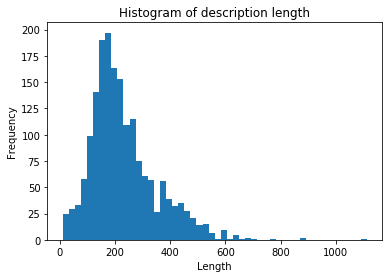

In [7]:
# descriptive statistics
ds.population_stats(mod_data_trunc, 'no_short', gs)
ds.length_distro(freq_df_trunc, gs, 'no_short')

In [8]:
# find matches for dictionary terms
dict_list = dh.compile_dicts(base_dicts, features_trunc)

Compiled matches and duds for gaucher_masculine_v2.
Compiled matches and duds for gaucher_feminine_v2.
Compiled matches and duds for superlatives_v2.
Compiled matches and duds for communal_orientation_v2.
Compiled matches and duds for grindstone_adjectives_v2.
Compiled matches and duds for ability_words_v2.
Compiled matches and duds for agentic_orientation_v2.
Compiled matches and duds for gorman_masculine_traits_v2.
Compiled matches and duds for gorman_feminine_traits_v2.
Compiled matches and duds for family_friendly_v2.
Compiled matches and duds for teaching_words_v2.
Compiled matches and duds for research_words_v2.


In [9]:
# calculate dictionary counts and proportions
dict_counts = dba.compute_dicts(dict_list, freq_df_trunc, mod_data_trunc, gs)
dict_combined = dba.compute_proportions(dict_list, dict_counts, gs)
print('Done counting dictionary terms.')

Done counting dictionary terms.


CIP_STEM_flag
Basic statistics for CIP_STEM_flag:
              gaucher_masculine_v2_prop                                     \
                                  count      mean       std  min       25%   
CIP_STEM_flag                                                                
NON-STEM                          913.0  0.006938  0.007218  0.0  0.000000   
STEM                              825.0  0.008858  0.007785  0.0  0.003289   

                                            gaucher_feminine_v2_prop  \
                    50%       75%       max                    count   
CIP_STEM_flag                                                          
NON-STEM       0.005464  0.010460  0.043478                    913.0   
STEM           0.007299  0.012945  0.042857                    825.0   

                        ...  teaching_words_v2_binary       \
                   mean ...                       75%  max   
CIP_STEM_flag           ...                                  
NON-STEM    

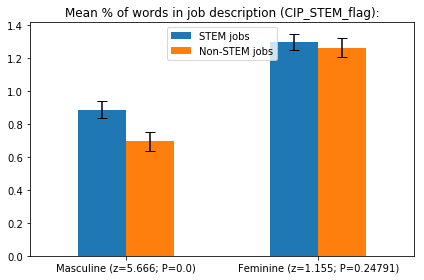

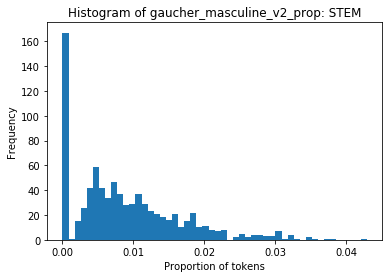

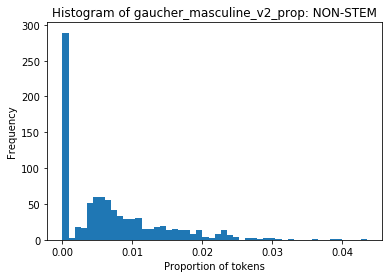

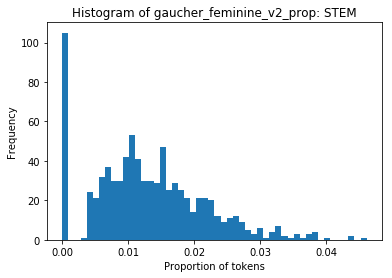

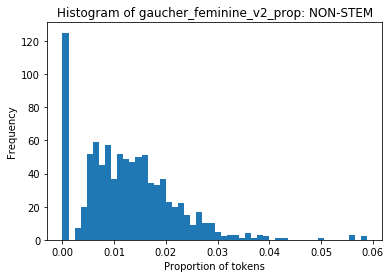

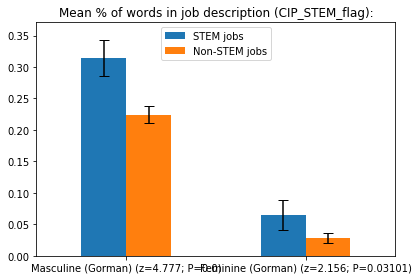

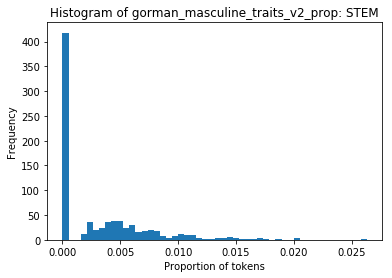

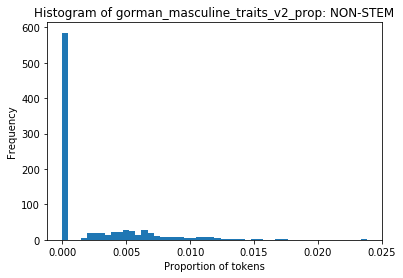

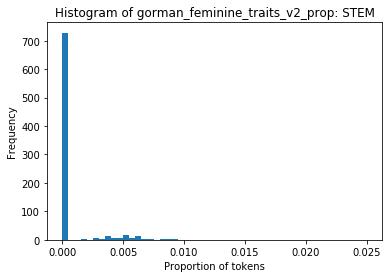

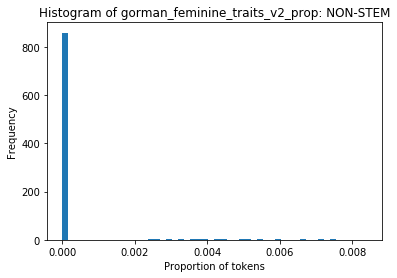

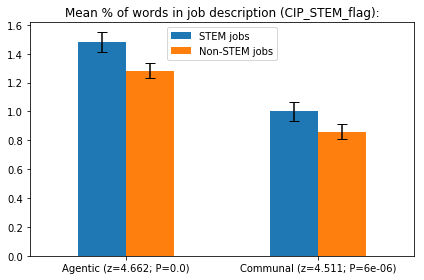

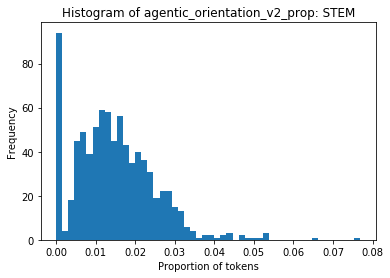

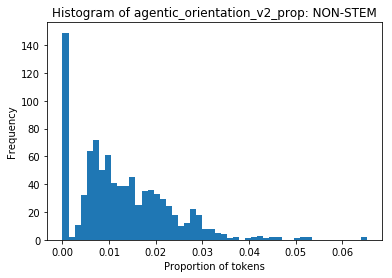

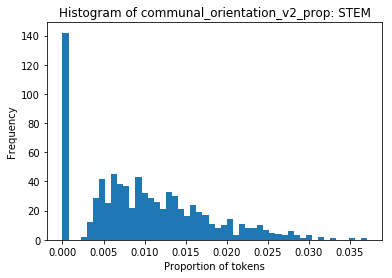

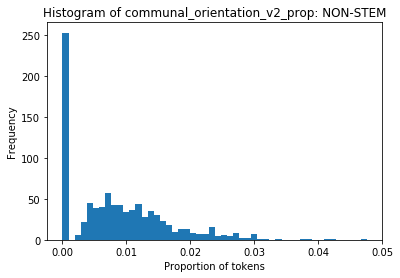

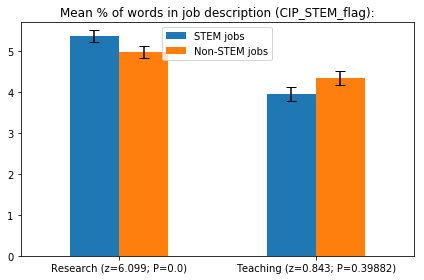

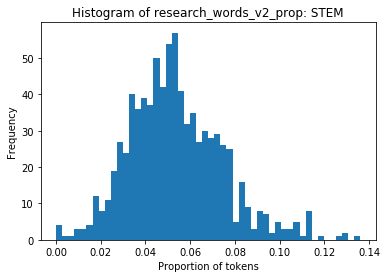

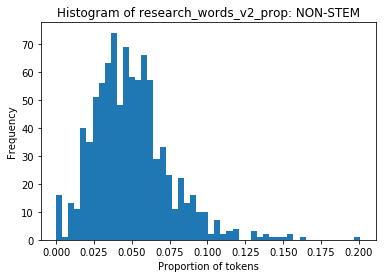

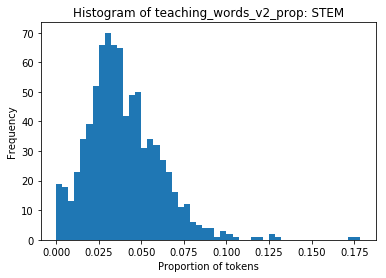

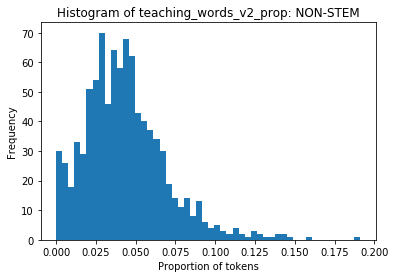

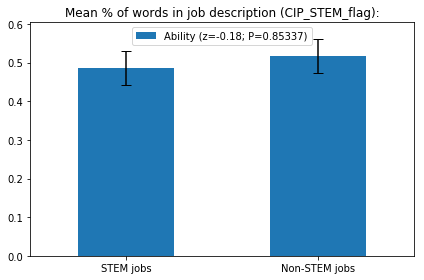

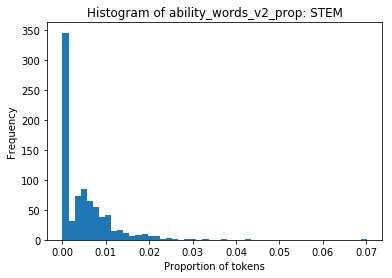

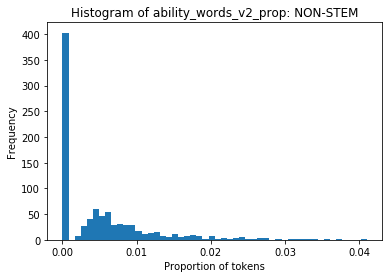

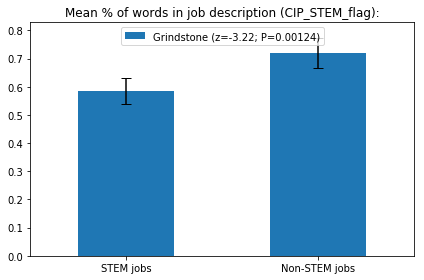

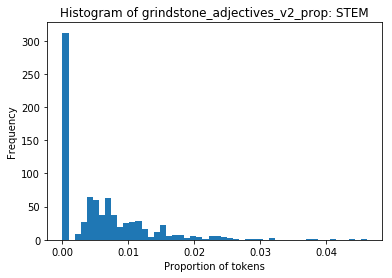

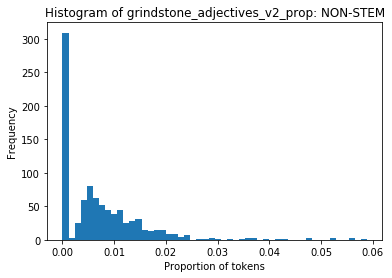

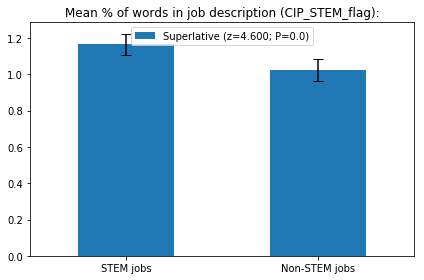

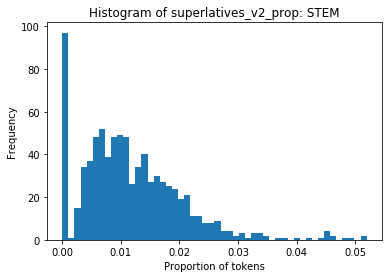

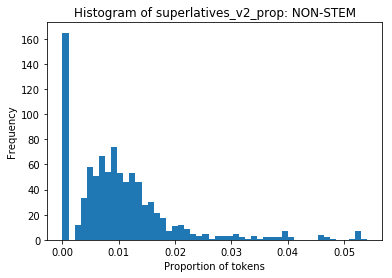

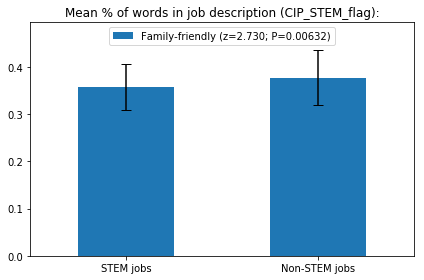

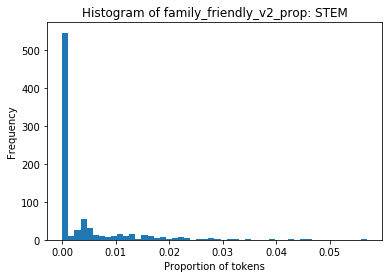

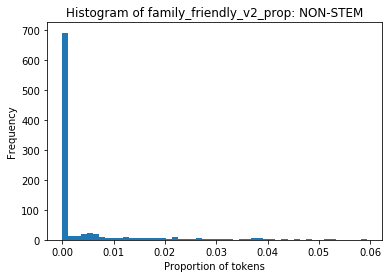

In [10]:
# visualize results
vh.stats_n_viz(dict_combined, dict_list, gs)

In [11]:
# A couple of example descriptions, annotated
annotate = vh.markup_descrs(dict_list, dict_combined)
print('Masculine Description:')
print()
print(dc.quick_mask(annotate['Most Masculine Descriptions'][5]))
print()
print('Feminine Description:')
print()
print(dc.quick_mask(annotate['Most Feminine Descriptions'][5]))

Masculine Description:

The Department of Education in the Graduate School of Education and Information Studies at the University of ---, --- --- announces an opening for a tenure track position in Qualitative Research Methods.  Candidates will be considered at the assistant associate professor level.    The successful candidate must have a program of research that utilizes qualitative methodology to address problems of education theory, policy, and practice in settings in and or out of school, and that is deeply reflective about the methods themselves.   We seek an ***individual*** who will serve as a core faculty member and add significantly to GSE&IS's qualitative methods program, and who will contribute scholarship to one or more of the Education Department's divisions and professional programs. Although the specific area of substantive research expertise is open, GSE&ISÃ¢ÂÂs mission includes at its core addressing issues of education equity, diversity, and social justice.  ***In

# Multivariate Results

_Note: These results use an older version of the data than what is presented above._


<img src="images/mascfem.png" width='900'>
<img src="images/mostmasc.png" width='900'>
<img src="images/mostfem.png" width='900'>
<img src="images/maleterms.png" width='900'>
<img src="images/femterms.png" width='900'>
<img src="images/withcontrols.png" width='900'>


# Limitations of existing dictionaries

* Poor recall due to _a priori_ identification of terms.
* Poor precision due to domain specificity.

<img src="images/Loughran.png" width='300'>

The gender dictionaries we employ suffer from a couple of potential issues, despite having been generated by experts and - at least sometimes - validated with survey or experimental methods.

<img src="images/GaucherDicts.png" width='500'>

# Dictionary Validation and Expansion Steps

In addition to reviewing lists of most and least frequent terms to look for anomalous results, we tried to come up with some other computational or at least automated ways of validating our dictionary counts.

## 1. WEM Analysis

We fit a WEM model to our data using gensim Word2Vec and then iterated through the matches from our dictionaries running .most_similar('term') on each. We used the results for heuristic purposes, identifying words that seemed to be generating anomalous results or words that suggested omitted terms. We performed KWIC analysis (see below) of the anomalous terms and the candidates for expansion.

The following cell includes code fitting the model and a sample .most_similar() call. (Note that this function has been deprecated, so this code will need to be updated soon.)

__Issues to Consider:__

1. Are there issues with using a WEM to analyze such a small data set?
2. Should we employ different hyperparameters?
3. Is there a more systematic way to use cosine similarity for dictionary expansion?
4. Is there a more systematic way to use cosine similarity for precision checking?

In [12]:
import gensim
# fitting model

def generate_wem(clean_data, dict_list):
    print('Fitting WEM model.')
    clean_data['descriptions_split'] = clean_data['descr_tokens'].apply(lambda x: x.split())

    model = gensim.models.Word2Vec(clean_data['descriptions_split'], size=500, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=50, batch_words=10000, workers=1)

    print("Model fit.")
    print()
    
    print('Sanity check - most similar to STEM terms:')
    print(model.most_similar(['science', 'engineering', 'mathematics', 'technology']))
    print()
    
    return model
        
model = generate_wem(mod_data_trunc, dict_list)

Fitting WEM model.
Model fit.

Sanity check - most similar to STEM terms:
[('statistics', 0.5201027989387512), ('sciences', 0.5067310333251953), ('electrical', 0.42126673460006714), ('henry', 0.40708833932876587), ('samueli', 0.39219367504119873), ('nuclear', 0.3540934920310974), ('foreign', 0.3515934944152832), ('pure', 0.3513186573982239), ('biology', 0.3457896113395691), ('mechanical', 0.34432488679885864)]



/Users/matthewcannon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [13]:
# loop through our dictionaries, identifying the terms most similar to each constiuent word
for dic in dict_list:
    print('MOST SIMILAR RESULTS FOR '+dic['name']+':\n')
    for w in dic['matches']:
        if w in model.wv.vocab:
            print('TERM: '+w)
            print(model.most_similar(w))
            print()

MOST SIMILAR RESULTS FOR gaucher_masculine_v2:

TERM: lead
[('genuinely', 0.41793394088745117), ('manage', 0.40488576889038086), ('pursue', 0.40157097578048706), ('supported', 0.3872402608394623), ('independent', 0.38685962557792664), ('fund', 0.38300031423568726), ('build', 0.3704543113708496), ('implement', 0.36968109011650085), ('sustain', 0.36730828881263733), ('develop', 0.3603662848472595)]

TERM: competitive
[('compensation', 0.3832817077636719), ('attractive', 0.38089531660079956), ('package', 0.3788680136203766), ('dependent', 0.31299471855163574), ('benefits', 0.30985644459724426), ('postdoctoral', 0.30966871976852417), ('salaries', 0.27588915824890137), ('activities', 0.2732112407684326), ('doctoral', 0.2601352632045746), ('ta', 0.25629913806915283)]

TERM: challenging
[('complexity', 0.7102935910224915), ('discover', 0.548560619354248), ('influences', 0.5181766152381897), ('analyze', 0.5154984593391418), ('conceptual', 0.5083605051040649), ('bayesian', 0.5070821046829224), 

/Users/matthewcannon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


[('monitoring', 0.6422054767608643), ('implantable', 0.6341625452041626), ('radiation', 0.6293786764144897), ('devices', 0.5908865928649902), ('minimal', 0.5844238996505737), ('nano', 0.5828114151954651), ('robotics', 0.5820622444152832), ('interfaces', 0.5809028148651123), ('sensors', 0.5802628993988037), ('prognosis', 0.5744321942329407)]

TERM: assistants
[('supervising', 0.43610572814941406), ('directing', 0.43351396918296814), ('normally', 0.40616267919540405), ('screenwriting', 0.3908841013908386), ('assisting', 0.37298113107681274), ('standard', 0.369884192943573), ('means', 0.36971816420555115), ('approximately', 0.3670671284198761), ('ba', 0.3648597300052643), ('enrollment', 0.3644137978553772)]

TERM: concerned
[('substantially', 0.6261543035507202), ('ã¢â\x80â\x9craceã¢â\x80â\x9d', 0.5104351043701172), ('employs', 0.4751948416233063), ('formations', 0.468411386013031), ('relates', 0.46839749813079834), ('examines', 0.45396220684051514), ('focuses', 0.4498597979545593), ('eco

[('advise', 0.46215683221817017), ('supervise', 0.4512292742729187), ('train', 0.420345664024353), ('continuing', 0.39477503299713135), ('accomplishment', 0.393795371055603), ('vigorous', 0.36602476239204407), ('undergraduates', 0.36522889137268066), ('designers', 0.3582896590232849), ('supported', 0.3472970426082611), ('mentor', 0.3468080163002014)]

TERM: educate
[('train', 0.42955535650253296), ('result', 0.3943813741207123), ('played', 0.38584455847740173), ('mcb', 0.35859590768814087), ('physicians', 0.3570381999015808), ('approximately', 0.35533905029296875), ('enrich', 0.3435487449169159), ('infections', 0.3314724266529083), ('north', 0.3307008743286133), ('formerly', 0.32620057463645935)]

TERM: educating
[('passionate', 0.4923996031284332), ('standards', 0.4580691456794739), ('organizationã¢â\x80â\x99s', 0.4428555369377136), ('abilities', 0.4356726408004761), ('reflection', 0.43228158354759216), ('longstanding', 0.4109726548194885), ('demonstrates', 0.41038304567337036), ('inn

## 2. WordNet Expansion

We used the [Princeton WordNet database](https://wordnet.princeton.edu/) to identify potential synonyms for each of our dictionary matches and the dictionary "duds". Terms that appeared to at least possibly be theoretically meaningful were subjected to KWIC analysis.

Sample code for generating WordNet is in the following cell. For illustrative purposes, it uses an arbitrary list based on some of the words from our teaching dictionary, but you could just as easily pass it a list of terms generated in one of the processing steps above.

__Issues to consider:__
1. Is there a way to utilize this database more effectively?
2. Is there a way to filter senses _ex ante_?

In [14]:
from nltk.corpus import wordnet as wn

word_list = ['counselor', 'rapport']

for term in word_list:
    print('CANDIDATE TERM: '+term+'\n\nSYNONYMS:\n')
    results = wn.synsets(term)
    syn_list = []
    for res_set in results:
        syn_list.extend(res_set.lemma_names())
    syn_list = set(syn_list)
    print('\n'.join(syn_list))
    print('\n')

CANDIDATE TERM: counselor

SYNONYMS:

pleader
counselor-at-law
counselor
counsellor
counsel
advocate


CANDIDATE TERM: rapport

SYNONYMS:

resonance
rapport




## 3. KWIC Analysis

Our "quick" and dirty method was to join all the descriptions into a string, and then iterate over the list of terms of interest, calling NLTK's .concordance_list() method on each.

Instead of performing this for each term, which would have effectively amounted to hand-verifying the coding of every single term of interest in every description, we used it primarily as a second-level check for (1) terms that we thought might be problematic for some reason (_e.g._, "committee") or (2) terms we were considering adding to our dictionaries (_e.g._, "star").

Our code for performing this analysis on some sample terms is below.

__Issues to Consider:__

1. Is there a better way to perform this check on a document-by-document, dictionary-by-dictionary, and term-by_term basis?
2. Is there utility in performing such a check?

In [15]:
import nltk

# combining all tokenized descriptions into a list
tokenized = ' '.join(list(mod_data['descr_tokens'])).split()

nltk_text = nltk.Text(tokenized)

test = nltk_text.concordance_list('greatest', 50)[0]
print(' '.join(test[0])+' ***'+test[1]+'*** '+' '.join(test[2])+'\n')

stateã¢ââs natural resources critical maintaining vibrant natural heritage healthy environments depend one ***greatest*** challenges managing wild vertebrates game non game species accurately identifying population



In [16]:
# sample results using smaller window
terms_of_interest = ['star', 'committee']
for t in terms_of_interest:
    kwic = nltk_text.concordance_list(t, 10)[:5]
    print('TERM OF INTEREST: '+t+'\n')
    for k in kwic:
        print(' '.join(k[0])+' ***'+k[1]+'*** '+' '.join(k[2])+'\n')

TERM OF INTEREST: star

large galaxy ***star*** surveys

large galaxy ***star*** surveys

large galaxy ***star*** surveys

large galaxy ***star*** surveys

large galaxy ***star*** surveys

TERM OF INTEREST: committee

zlotnik search ***committee*** chair

zlotnik search ***committee*** chair

zlotnik search ***committee*** chair

chair search ***committee*** department

search search ***committee*** chair

